#  Lightcurves, transits, and TESS! Oh My!

Assumed knowledege:

1. CCD operation and structure
2. Point-spread functions
3. Plotting tools
4. Model fitting

### Step 0: imports

In [ ]:
# Run this once to install a python package for downloading lightcurves from the TESS mission
# ! python -m pip install lightkurve --upgrade

In [ ]:
# these should be familar
import scipy
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

# this package will allow us to make progress bars
from tqdm import tqdm

# We can beautify our plots by changing the matpltlib setting a little
plt.rcParams['font.size'] = 18
matplotlib.rcParams['axes.linewidth'] = 2
matplotlib.rcParams['font.family'] = "serif"

# Step 1: loading data from the TESS mission


Like the last notebook, the function below uses the python package `lightkurve` to load data from the TESS mission. To search for exoplanets, TESS takes pictures of a patch of the sky once every 2 minutes. The function `load_TESS_data` takes in the name of a star and the size of image cutout we want to downdload (centered on the star).

**Exercise:** Run the code below to load in the functions we used in the last notebook.

In [1]:
# this function downloades TESS lightcurves (I recommend we supply this function
# and have the student's use it as a black box)

def load_TESS_data(target, cutout_size=20, verbose=False, exptime=None):
    """
    Download TESS images for a given target.

    inputs:
        target: str, same of star (ex. TOI-700)
        cutout_size: int, size of the returned cutout
                     (in units of pixels)
        verbose: bool, controls whether to include printouts
        exptime: str, determines if we use short or long cadence mode
                 (if None, defaults to first observing semester)
    outputs:
        time: numpy 1D array
        flux: numpy 3D array (time x cutout_size x cutout_size)
    """

    import lightkurve as lk

    # find all available data
    search_result = lk.search_tesscut(target)
    if exptime == 'short':
        search_result = search_result[search_result.exptime.value==search_result.exptime.value.min()]
    elif exptime == 'long':
        search_result = search_result[search_result.exptime.value==search_result.exptime.value.max()]
    print(search_result)

    # select the first available observing sector
    if exptime:
        search_result = search_result[search_result.exptime == exptime]
    search_result = search_result[search_result.mission == search_result.mission[0]]

    # download it
    tpf = search_result.download_all(cutout_size=cutout_size)[0]

    # convert it to a numpy array format
    flux = np.array([
        tpf.flux[i].value for i in range(len(tpf.flux)) if tpf.flux[i].value.min()>0
    ])
    flux_err = np.array([
        tpf.flux_err[i].value for i in range(len(tpf.flux_err)) if tpf.flux[i].value.min()>0
    ])

    time = np.array([
        tpf.time.value[i] for i in range(len(tpf.flux)) if tpf.flux[i].value.min()>0
                    ])

    return time, flux, flux_err

In [2]:
def plot_cutout(image, logscale = False, vrange = [1,99]):
    """
    Plot 2D image.

    inputs:
        image: 2D numpy array
        logscale: bool, if True plots np.log10(image)
        vrnge: list, sets range of colorbar
               (based on percentiles of 'image')
    """
    if logscale:
        image = np.log10(image)

    q = np.percentile(image, q = vrange)
    plt.imshow( image, vmin = q[0], vmax = q[1] )
    plt.show()

def psf(x,y,sigma,scale,bkg,xmu=0,ymu=0,unravel=False):
    """
    Symmetric 2D point-spread function (PSF)

    inputs:
        x: np.ndarray, where to evaluate the PSF
        y: np.ndarray, where to evaluate the PSF
        sigma: float, width of the PDF
        scale: float, integrated area under the PSF
        bkg: float, background flux level
        xmu: float, center of PSF in x
        ymu: float, center of PSF in y
    outputs:
        PSF evalauted at x and y
    """
    exponent = (np.power(x-xmu,2) + np.power(y-ymu,2) ) / sigma**2

    mod = scale * np.exp(-exponent) / (2*np.pi*sigma**2) + bkg
    if unravel:
        return mod.ravel()
    else:
        return mod

def residual(theta, x, y, z, z_err):
    sigma, scale, bkg, xmu, ymu = theta

    model = psf(x,y,sigma=sigma,scale=scale,bkg=bkg,xmu=xmu,ymu=ymu)

    chi = np.power(model - z,2)/z_err**2

    return np.sum(chi)

**Exercise:** Run the code below to load all the TESS data for one small patch of the sky. We'll center our images on the same variable star from the last notebook.

In [ ]:
target = 'Gaia_DR2279382060625871360'
cutout_size = 20 # dimensions of the image in pixels x pixels
time, flux, flux_err = load_TESS_data(target,verbose=True,cutout_size=cutout_size)

SearchResult containing 4 data products.

 #     mission     year  author exptime        target_name         distance
                                   s                                arcsec 
--- -------------- ---- ------- ------- -------------------------- --------
  0 TESS Sector 19 2019 TESScut    1426 Gaia_DR2279382060625871360      0.0
  1 TESS Sector 59 2022 TESScut     158 Gaia_DR2279382060625871360      0.0
  2 TESS Sector 73 2023 TESScut     158 Gaia_DR2279382060625871360      0.0
  3 TESS Sector 86 2024 TESScut     158 Gaia_DR2279382060625871360      0.0


In [ ]:
# where to evaluate our PSF
x = np.arange(flux.shape[1])
y = np.arange(flux.shape[2])
X,Y = np.meshgrid(x,y)

**Exercise:** To check things loaded well, run the code below to plot the mean of the TESS cutouts.

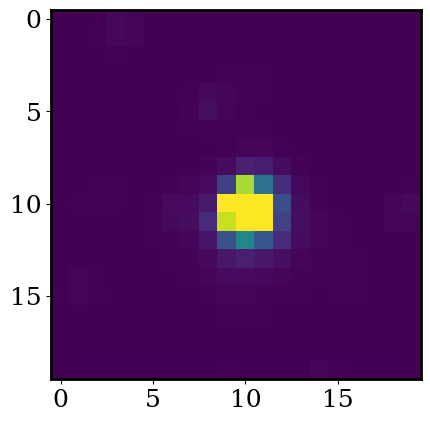

In [ ]:
# linear scale
plot_cutout(np.mean(flux,axis=0))

**Exercise:** Using your code from the end of the last notebook, use `scipy.optimize.minimize` find the best-fit `scale` for each TESS cutout.

In [ ]:
# answer here

# Step 3: finding the oscillation period

We've now successfully made a lightcurve for our star! By eye we can see the star is **variable** (it's flux is periodically varying with time). How long does it take to complete a cycle?

Let's start by simply fitting the lightcurve with a simple periodic function: a sine wave.

**Exercise:** Write the function `sinusoid_model(time,ampl,period,phase,background)` where `time` is a numpy array, and `ampl,period,phase,background` all all floats. The function shound return:
$$  y(t) = A \sin[t \times (2\pi / \mathrm{period})+ \mathrm{phase}] + \mathrm{background} $$
Plot the sine wave alongside the lightcurve we calculated above. Set the parameters of `sinusoid_model` hand to best fit the lightcurve.

In [5]:
# answer here

Now let's try automating the process.

**Exercise:** For a grid of periods (`0 < period < 5`) and phases (`0 < phase < 2 * np.pi`), calculate the goodness of fit:
 `np.sum(np.power(lightcurve-model,2) )`. For each combination of period and phase, plot period versus phase on a scatter plot with the color of the marker set by `np.log10` of goodness of fit. Leave `ampl=100` and `background=600`.


For ease of reading, try setting your colorbar to go from `vmin = 6.` and `vmax=7.3`

Compare the best fit sine wave with your by hand fit.

In [6]:
# answer here

Our sine model works okay but certainly isn't a perfect fit to the data. Instead let's try a Lomb-Scargle periodogram. This method finds the periodic signals in a dataset using Fourier transforms. See some background: https://iopscience.iop.org/article/10.3847/1538-4365/aab766/pdf


**Exercise:** Run the code below to calculate the Lomb-Scargle periodogram. Plot `period` vs. `power`. Use a log scale on the x-axes.

This tell us how much a particular period contributes to the observed signal (so spikes tell us that period is strongly present in the data).

In [ ]:
from astropy.timeseries import LombScargle

periods   = 10**np.linspace(np.log10(2),2,1000)
frequency = 1/periods
power = LombScargle(time,lightcurve).power(frequency)

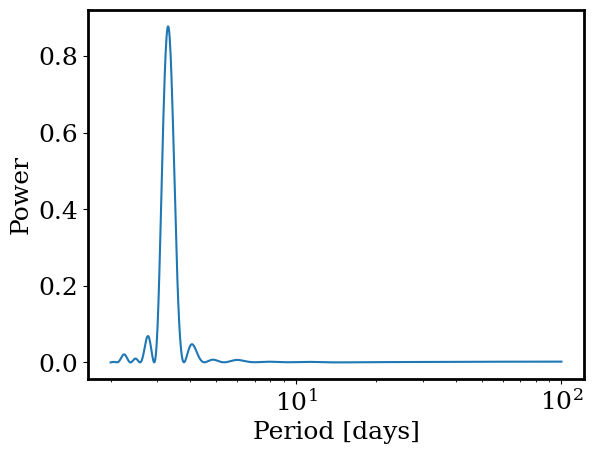

In [ ]:
plt.plot(periods,power)
_ = plt.xlabel('Period [days]')
_ = plt.ylabel('Power')
plt.xscale('log')

In [ ]:
best_period = periods[np.argmax(power)]
print(f'Best: {best_period:.3} days')

Best: 3.29 days


**Exercise:** How does the peak from the Lomb-Scargle periodogram compare to the best fit period you found with out sine function above?

answer here

# Step 4: finding planets

Above we measured the lightcurve for a star from TESS cutouts and then calculated it's oscillation period. Let's now repeat that process for a star known to host a transiting planet!

Let's start with a relatively bright star hosting a Jupiter sized planet:

**Exercise:**  Run the code below to load the TESS data.

In [ ]:
target = 'Gaia_DR24624979393181971328'

period_tess = 2.084544     # days
radius_planet_tess = 1.286 # R_jup
radius_star_tess   = 1.17  # R_sun

In [ ]:
cutout_size = 20 # dimensions of the image in pixels x pixels

# stamps
time, flux, flux_err = load_TESS_data(target,verbose=True,cutout_size=cutout_size,exptime=158)

SearchResult containing 36 data products.

 #     mission     year  author exptime         target_name         distance
                                   s                                 arcsec 
--- -------------- ---- ------- ------- --------------------------- --------
  0 TESS Sector 06 2018 TESScut    1426 Gaia_DR24624979393181971328      0.0
  1 TESS Sector 05 2018 TESScut    1426 Gaia_DR24624979393181971328      0.0
  2 TESS Sector 04 2018 TESScut    1426 Gaia_DR24624979393181971328      0.0
  3 TESS Sector 03 2018 TESScut    1426 Gaia_DR24624979393181971328      0.0
  4 TESS Sector 01 2018 TESScut    1426 Gaia_DR24624979393181971328      0.0
  5 TESS Sector 02 2018 TESScut    1426 Gaia_DR24624979393181971328      0.0
  6 TESS Sector 13 2019 TESScut    1426 Gaia_DR24624979393181971328      0.0
  7 TESS Sector 11 2019 TESScut    1426 Gaia_DR24624979393181971328      0.0
  8 TESS Sector 12 2019 TESScut    1426 Gaia_DR24624979393181971328      0.0
  9 TESS Sector 08 2019 TESScut  

**Exercise:**  Like we did above, use `scipy.optimize.minimize` to extract the lightcurve from the TESS cutouts by fitting the images with the 2-d gaussian model.

Use the same ranges for the parameters as above.

Plot the lightcurve. What do you notice? Can you spot transits by eye?

In [ ]:
# answer here

178it [00:03, 49.17it/s]

In addition to transits, we can also see the star is undergoing a more steady change in brightness with time. We want to study the transits to let's try to remove the non-transit flux changes (this called "detrending" the lightcurve).

**Exercise:** Use the function `median_filter(x,y,width)`, where `x,y` are arrays (for example time and lightcurve) and `width` is a float, to detrend the lightcurve. For each x value, the function returns with the median y within width of the given x value (i.e., a rolling median filter).

Detrend the lightcurve by subtracting `median_filter(x,y,width)`. Choose `width` such that the transits are not affected by the detrending but the long term trends are removed.

Plot the detrended lightcurve.


In [ ]:
def median_filter(x,y,width):
    smooth = []
    for xi in x:
        C = np.abs(xi-x)<width/2
        smooth.append(np.median(y[C]))
    return np.array(smooth)

In [ ]:
# answer here

**Exercise:** use the Lomb-Scargle periodogram to find the period of the planet.

Hint: search periods longer than 1 day.

In [ ]:
# answer here

We now have a clean lightcurve and a solid estimate of the planet's orbital period. So we have everything we need to study the planet! Unfortunately, this is difficult with individual transits, because each transit is quite a noisy measurement.  We can overcome this challenge by combining the individual transits into one 'average' transit.

**Exercise:** Since the planet's orbital period is constant, the transit times should follow a simple formula:
$$ T(n) = T_0 + P \times n $$
where $T(n)$ is the $n$th transit time (i.e., $n=0,1,2,\dots$), $T_0$ is the first observed transit time, and $P$ is the orbital period.
This means we can "fold" all the individual transits on top of each other to create a higher signal average transit, if we know the planet's period.
Use the provided function `phase_it` to fold the light curve to the Lomb-Scargle period and plot the folded lightcurve. Change the x limits to zoom in on the transit. Be sure to use the detrended light curve.



In [ ]:
def phase_it(x,y,period):
    x_phased = (x/period)%1
    y_phased = y[np.argsort(x_phased)]

    return x_phased[np.argsort(x_phased)], y_phased

In [ ]:
x_phased, y_phased = phase_it(time, lc_detrended, period) # phase

In [ ]:
# answer here

We now have a very clear transit signal to study!

**Exercise:** Above we plotted the detrended lightcurve (i.e., the observed lightcurve minus the smooth median filter). Now plot the detrended lightcurve divided by the observed lightcurve. This way we now looking at the fractional change in flux.

By eye estimate the transit depth and calculate the planet to star size ratio:
$$\delta = (R_p / R_\star)^2$$

In [ ]:
# answer here

**Exercise:** The provided function `transit_model(phase, depth, duration, ingress)` describes the shape of a transit with a few free paremters. Try changing the transit depth, duration, and ingress time to fit the observed shape.

In [ ]:
def transit_model(phase, midpoint, depth, duration, ingress):

    def norm(x):
        return (x-x.min()) / (x.max() - x.min())

    model = np.ones_like(phase)

    start = midpoint - duration/2 - ingress
    end   = midpoint + duration/2 + ingress


    C_ingress = (phase > start) & (phase < midpoint - duration/2)
    C_egress  = (phase < end)   & (phase > midpoint + duration/2)

    if len(C_ingress[C_ingress])>3:
        model[C_ingress] = 1 - depth * norm(phase[C_ingress])

    if len(C_egress[C_egress])>3:
        model[C_egress]  = (1-depth) + depth * norm(phase[C_egress])

    model[np.abs(phase-midpoint)<duration/2] = 1-depth

    return model-1

def residual_transit_model(theta, phase, lc):
    midpoint, depth, duration, ingress = theta

    model = transit_model(phase, midpoint, depth, duration, ingress)

    return np.sum( np.power(model - lc,2) )

In [ ]:
xp = np.linspace(0,1,10000)
yp = transit_model(xp, 0.1, 0.015, 0.02, 0.01)

In [ ]:
# answer here

**Exercise:** use the code below to fit the folded lightcurve with `transit_model` using `scipy.optimize.differential_evolution`. Plot the best fit transit model against the data. How does the fit transit depth compare to your by eye estimate?

In [ ]:
out = scipy.optimize.differential_evolution(residual_transit_model,
                          bounds   = [
                              (0.05, 0.1),
                              (0,0.02),
                              (0,0.05),
                              (0,0.05)],
                          args = (x_phased, y_phased),
            )

In [ ]:
xp = np.linspace(0,1,1000)
yp = transit_model(xp, *out.x)

_=plt.scatter(x_phased, y_phased,alpha=0.2)
_=plt.plot(xp,yp)

plt.ylabel('Normalized flux')
plt.xlabel('Phase')
plt.xlim([0.,0.2])
plt.show()